# Overall View

in this notebook we want to predict air quality.

**Dataset:**

The data is about Pollutant Standards Index (PSI), specifically pm2.5. There are four bands on the PM2.5 concentration scale: 0 to 55 for normal, 56 to 150 for elevated, 151 to 250 for high, and very high for any higher readings.

Beyond national air quality levels, the data is also split by regions: North, South, East, West and Central.

**Solutions:**

as you know, it,s a time series problem. 

1- The first part of notebook is time series classification. we divided data in 4 range of normal, elevated, high and very high. as the quality of air in this dataset is not worth than 150 then we have 2 class so doing this task is a bit pointless. 

2- The last part of notebook is time series regression.  

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import numpy, keras, IPython
import matplotlib.pyplot as plt
from pandas import read_csv
import pandas as pd
import math
import numpy as np
from numpy import array
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras import optimizers
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers import BatchNormalization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, ModelCheckpoint
from IPython.display import SVG
from pathlib import Path
import IPython
from pylab import rcParams
import matplotlib.pylab as pylab
%matplotlib inline

In [17]:
psi_df = pd.read_csv("/content/drive/My Drive/YapAiTek/psi_df_2016_2019.csv")
psi_df.head()

,national,south,north,east,central,west,timestamp
0,47,44,37,47,47,34,2016-02-07T18:00:00+08:00
1,59,57,54,59,57,56,2016-02-08T23:00:00+08:00
2,59,57,55,59,57,56,2016-02-09T01:00:00+08:00
3,59,57,55,59,56,56,2016-02-09T02:00:00+08:00
4,59,58,55,59,56,56,2016-02-09T03:00:00+08:00


i drop timestamp feature but in future work we can keep it as we shuffle the data:

In [18]:
psi_df = psi_df.drop(['timestamp'], axis=1)

In [19]:
psi_df.shape

(30022, 6)

data info(no NAN value):

In [20]:
psi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30022 entries, 0 to 30021
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   national  30022 non-null  int64
 1   south     30022 non-null  int64
 2   north     30022 non-null  int64
 3   east      30022 non-null  int64
 4   central   30022 non-null  int64
 5   west      30022 non-null  int64
dtypes: int64(6)
memory usage: 1.4 MB


In [21]:
psi_df.describe()

,national,south,north,east,central,west
count,30022.000000,30022.000000,30022.000000,30022.000000,30022.000000,30022.000000
mean,50.502232,54.294351,54.003464,52.491007,52.885884,50.299014
std,13.107219,10.844489,10.991413,10.365553,11.832203,11.672157
min,13.000000,20.000000,19.000000,14.000000,13.000000,16.000000
25%,42.000000,50.000000,49.000000,47.000000,47.000000,43.000000
50%,53.000000,54.000000,55.000000,54.000000,54.000000,52.000000
75%,58.000000,59.000000,59.000000,58.000000,59.000000,57.000000
max,143.000000,154.000000,145.000000,131.000000,154.000000,143.000000



# time series classification

In [22]:
new_psi_df = pd.DataFrame()
def transform_sentiment(x,column):
  if x > 0 and x <= 55:
      return 0
  elif x > 55 and x <= 150:
      return 1
  elif x > 150 and x <= 250:
      return 2
  else:
      return 3
for column in psi_df:
  new_psi_df[column] = psi_df[column].apply(lambda x: transform_sentiment(x,column))

In [23]:
new_psi_df.head()

,national,south,north,east,central,west
0,0,0,0,0,0,0
1,1,1,0,1,1,1
2,1,1,0,1,1,1
3,1,1,0,1,1,1
4,1,1,0,1,1,1


In [24]:
dataset = new_psi_df.values
print('type of dataset: ', type(dataset))
print('length of dataset: ', len(dataset), '\nshape of dataset: ', dataset.shape)

type of dataset:  <class 'numpy.ndarray'>
length of dataset:  30022 
shape of dataset:  (30022, 6)


In [26]:
def split_sequence(sequence, n_steps, pred_steps):
	X, y = list(), list()
	for i in range(len(sequence)-pred_steps-n_steps):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		# if end_ix > len(sequence)-end_ix-pred_steps :
		# 	break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix+pred_steps][0]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [27]:
# choose a number of time steps
n_steps = 10
pred_steps = 20

# split into samples
X, y = split_sequence(dataset, n_steps, pred_steps)
print(len(y))
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

#shuffling after making windows
X, y = shuffle(X, y)

# one hot labels
depth = 4
y = tf.one_hot(y, depth)
y = y.numpy()

# # split into train and test sets
train_size = int(len(X) * 0.6)
val_size = train_size + int(len(X) * 0.2)
trainX, validationX, testX = X[0:train_size,:], X[train_size:val_size,:], X[val_size:,:]
trainY, validationY, testY = y[0:train_size,:], y[train_size:val_size,:], y[val_size:,:]

n_features = len(trainX[0][0])

print('the shape of trainx: ', trainX.shape)
print('the shape of validationx: ', validationX.shape)
print('the shape of testx: ', testX.shape)
print('the shape of trainy: ', trainY.shape)
print('the shape of validationy: ', validationY.shape)
print('the shape of testy: ', testY.shape)
print(trainX[:2])

29992
{0: 19236, 1: 10756}
the shape of trainx:  (17995, 10, 6)
the shape of validationx:  (5998, 10, 6)
the shape of testx:  (5999, 10, 6)
the shape of trainy:  (17995, 4)
the shape of validationy:  (5998, 4)
the shape of testy:  (5999, 4)
[[[0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [1 0 1 0 0 0]
  [0 0 0 0 0 0]
  [1 0 0 1 0 0]
  [1 1 0 1 0 0]
  [1 1 0 1 0 0]
  [1 1 0 1 0 0]]

 [[1 0 1 0 0 0]
  [1 0 1 0 0 0]
  [1 0 1 0 0 0]
  [1 0 1 0 0 0]
  [1 0 1 0 0 0]
  [1 0 1 0 0 0]
  [1 0 1 0 0 0]
  [1 0 1 0 0 0]
  [1 0 1 0 0 0]
  [1 0 1 0 0 0]]]


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 50)            11400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
Total params: 32,154
Trainable params: 32,154
Non-trainable params: 0
_________________________________________________________________


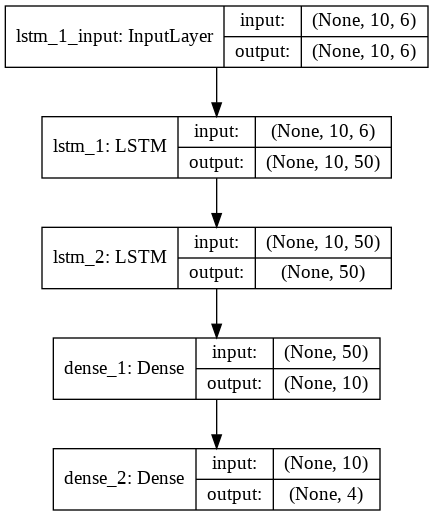

In [28]:
# define StackedLSTMmodel:
model = Sequential()
model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
# model.add(Dropout(0.01))
model.add(Dense(10))
model.add(Dense(4))
model.compile(optimizer="RMSprop", loss='mse', metrics=['accuracy'])
model.summary()
# SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))
keras.utils.plot_model(model, to_file='LSTM.png', show_shapes=True)
IPython.display.Image('LSTM.png')


In [29]:
history = model.fit(trainX, trainY, epochs=5, verbose = 1, validation_data=[testX,testY])

Train on 17995 samples, validate on 5999 samples
Epoch 1/5
17995/17995 [==============================] - 9s 481us/step - loss: 0.0866 - accuracy: 0.7706 - val_loss: 0.0801 - val_accuracy: 0.7831
Epoch 2/5
17995/17995 [==============================] - 8s 433us/step - loss: 0.0815 - accuracy: 0.7790 - val_loss: 0.0805 - val_accuracy: 0.7790
Epoch 3/5
17995/17995 [==============================] - 8s 434us/step - loss: 0.0800 - accuracy: 0.7836 - val_loss: 0.0821 - val_accuracy: 0.7800
Epoch 4/5
17995/17995 [==============================] - 8s 447us/step - loss: 0.0790 - accuracy: 0.7856 - val_loss: 0.0779 - val_accuracy: 0.7846
Epoch 5/5
17995/17995 [==============================] - 8s 449us/step - loss: 0.0785 - accuracy: 0.7867 - val_loss: 0.0763 - val_accuracy: 0.7948


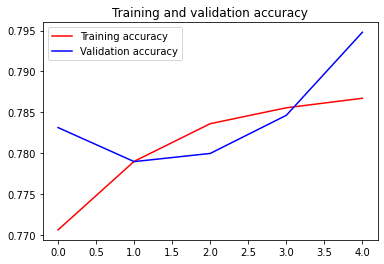

<Figure size 432x288 with 0 Axes>

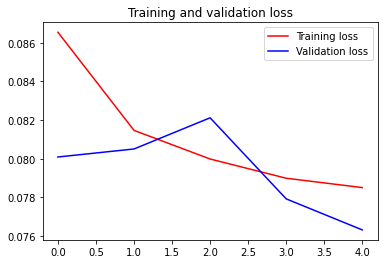

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [31]:
y_pred = model.predict_classes(testX)
testY = np.argmax(testY, axis=1)

In [32]:
precision_score(testY, y_pred, average='macro')

0.7780798593947382

In [33]:
accuracy_score(testY, y_pred)

0.7947991331888649

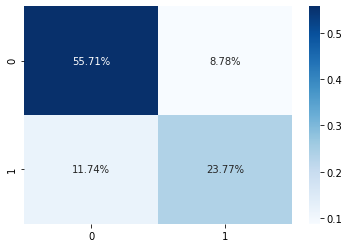

In [34]:
cf_matrix = confusion_matrix(testY, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# time series regression

In [56]:
dataset2 = psi_df.values
print('type of dataset: ', type(dataset2))
print('length of dataset: ', len(dataset), '\nshape of dataset: ', dataset2.shape)
print(dataset[0])

#Normalizing the data
scaler = MinMaxScaler(feature_range = (0, 1))
dataset2 = scaler.fit_transform(dataset2)
print(dataset2[0])

type of dataset:  <class 'numpy.ndarray'>
length of dataset:  30022 
shape of dataset:  (30022, 6)
[47 44 37 47 47 34]
[0.26153846 0.17910448 0.14285714 0.28205128 0.24113475 0.14173228]


In [74]:
# split into train, validation and test sets
train_size = int(len(dataset2) * 0.6)
val_size = train_size + int(len(dataset2) * 0.2)
train, validation, test = dataset2[0:train_size,:], dataset2[train_size:val_size,:], dataset2[val_size:,:]

# choose a number of time steps
n_steps = 10
pred_steps = 5

# split into samples
trainX, trainY = split_sequence(train, n_steps, pred_steps)
validationX, validationY = split_sequence(train, n_steps, pred_steps)
testX, testY = split_sequence(test, n_steps, pred_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 6
TrainX = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))
TestX = testX.reshape((testX.shape[0], testX.shape[1], n_features))
print('the shape of trainx: ', TrainX.shape)
print('the shape of testx: ', TestX.shape)
print('the shape of trainy: ', trainY.shape)
print('the shape of testy: ', testY.shape)
print(trainX[:2])

the shape of trainx:  (17998, 10, 6)
the shape of testx:  (5990, 10, 6)
the shape of trainy:  (17998,)
the shape of testy:  (5990,)
[[[0.26153846 0.17910448 0.14285714 0.28205128 0.24113475 0.14173228]
  [0.35384615 0.2761194  0.27777778 0.38461538 0.31205674 0.31496063]
  [0.35384615 0.2761194  0.28571429 0.38461538 0.31205674 0.31496063]
  [0.35384615 0.2761194  0.28571429 0.38461538 0.30496454 0.31496063]
  [0.35384615 0.28358209 0.28571429 0.38461538 0.30496454 0.31496063]
  [0.35384615 0.28358209 0.28571429 0.38461538 0.30496454 0.31496063]
  [0.35384615 0.28358209 0.28571429 0.38461538 0.31205674 0.31496063]
  [0.36153846 0.28358209 0.28571429 0.39316239 0.31205674 0.31496063]
  [0.36153846 0.28358209 0.29365079 0.39316239 0.31205674 0.31496063]
  [0.36923077 0.28358209 0.3015873  0.4017094  0.31205674 0.31496063]]

 [[0.35384615 0.2761194  0.27777778 0.38461538 0.31205674 0.31496063]
  [0.35384615 0.2761194  0.28571429 0.38461538 0.31205674 0.31496063]
  [0.35384615 0.2761194  0

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 10, 256)           269312    
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 467,733
Trainable params: 467,733
Non-trainable params: 0
_________________________________________________________________


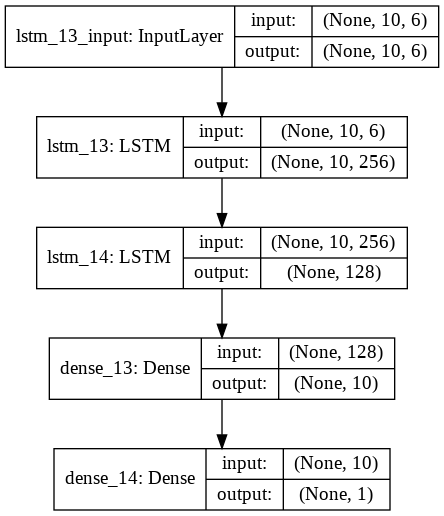

In [75]:
# define StackedLSTMmodel:
model2 = Sequential()
model2.add(LSTM(256, activation='relu',return_sequences=True, input_shape=(n_steps, n_features)))
model2.add(LSTM(128, activation='relu'))
# model.add(Dropout(0.01))
model2.add(Dense(10))
model2.add(Dense(1))
model2.compile(optimizer="RMSprop", loss='mse')
model2.summary()
# SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))
keras.utils.plot_model(model2, to_file='LSTM.png', show_shapes=True)
IPython.display.Image('LSTM.png')


In [79]:
history2 = model2.fit(trainX, trainY, epochs=50, verbose = 1, validation_data=[validationX, validationY])

Train on 17998 samples, validate on 17998 samples
Epoch 1/50
17998/17998 [==============================] - 44s 2ms/step - loss: 7.6424e-04 - val_loss: 7.9875e-04
Epoch 2/50
17998/17998 [==============================] - 44s 2ms/step - loss: 7.5992e-04 - val_loss: 7.0220e-04
Epoch 3/50
17998/17998 [==============================] - 44s 2ms/step - loss: 7.5267e-04 - val_loss: 7.5361e-04
Epoch 4/50
17998/17998 [==============================] - 44s 2ms/step - loss: 7.4659e-04 - val_loss: 7.1846e-04
Epoch 5/50
17998/17998 [==============================] - 44s 2ms/step - loss: 7.4105e-04 - val_loss: 7.8300e-04
Epoch 6/50
17998/17998 [==============================] - 44s 2ms/step - loss: 7.2117e-04 - val_loss: 7.8262e-04
Epoch 7/50
17998/17998 [==============================] - 44s 2ms/step - loss: 7.2975e-04 - val_loss: 6.7492e-04
Epoch 8/50
17998/17998 [==============================] - 44s 2ms/step - loss: 7.1946e-04 - val_loss: 6.2275e-04
Epoch 9/50
17998/17998 [======================

In [80]:
testPredict = model2.predict(testX)

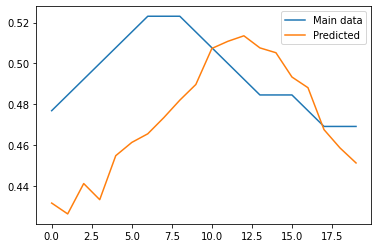

In [81]:
plt.plot(testY[-20:], label='Main data')
# plt.plot(trainPredictPlot)
plt.plot(testPredict[-20:], label='Predicted')
# plt.show()
plt.legend()

In [90]:
from sklearn.metrics import r2_score
print('R^2 is: ', r2_score(testY, testPredict)) 

mse = np.mean(tf.keras.losses.mse(testPredict, testY))
np.mean(mse)

R^2 is:  0.9022921553702168


0.023963279140049937